In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.networks import SuperMultiDiGraph
from krxns.cheminfo import draw_reaction
from IPython.display import SVG
import json
from collections import defaultdict
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
whitelist_fn = "top_25_whitelist"
rxns_fn = "sprhea_240310_v3_mapped"
atom_lb = 0.2
multi_nodes = True
ds = 1
value_fcn = 'tanimoto'

In [ ]:
# Load known reaction data
with open(filepaths['data'] / f"{rxns_fn}.json", 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['coreactants'] / f"{whitelist_fn}.json", 'r') as f:
    coreactant_whitelist = json.load(f)

analysis_dir = filepaths['results'] / "pathwise_value_fcn" / rxns_fn 

with open(analysis_dir / f"topk_{value_fcn}_{whitelist_fn}_atom_lb_{int(atom_lb * 100)}p_multi_nodes_{multi_nodes}_ds_{ds}.json", 'r') as f:
    topks = str2int(json.load(f))

path_values = pd.read_parquet(analysis_dir / f"pathwise_{value_fcn}_{whitelist_fn}_atom_lb_{int(atom_lb * 100)}p_multi_nodes_{multi_nodes}_ds_{ds}.parquet")

kcs, smi2id = extract_compounds(krs) # Get known compounds

In [4]:
G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    coreactant_whitelist=coreactant_whitelist,
    atom_lb=atom_lb,
    add_multi_mol_nodes=multi_nodes
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

print(G.number_of_nodes(), G.number_of_edges())

11785 22113


In [21]:
paths = G.shortest_path()

# Filter out self-paths
tmp = {}
for i in paths:
    destinations = {j: elt for j, elt in paths[i].items() if i != j}
    if destinations:
        tmp[i] = destinations
paths = tmp

<class 'networkx.utils.decorators.argmap'> compilation 4:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


In [22]:
path_lens = {}
for i in paths:
    for j in paths[i]:
        path_lens[(i, j)] = len(paths[i][j]) - 1

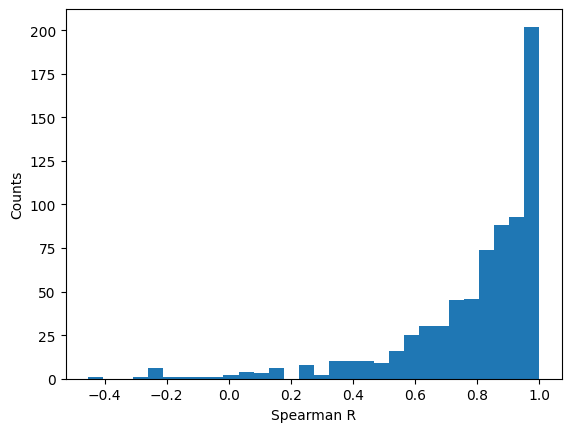

In [23]:
spearman_rs = path_values['spearman_r']
fig, ax = plt.subplots()
ax.hist(spearman_rs, bins=30)
ax.set_ylabel("Counts")
ax.set_xlabel("Spearman R")
plt.show()

In [24]:
path_values.head()

,starter_id,target_id,path_values,spearman_r
0,0,1,"0.76229507,1.0",1.000000
1,0,2,"0.96747965,1.0",1.000000
2,0,3,"0.8677686,0.852459,1.0",0.500000
3,0,4728,"0.8347107,0.8196721,0.96190476,1.0",0.800000
4,0,2475,"0.14634146,0.14634146,0.1574074,1.0",0.948683


In [27]:
negs = path_values.index[path_values['spearman_r'] < 0].to_list()
zeros = path_values.index[abs(path_values['spearman_r']) < 1e-2].to_list()
ones = path_values.index[abs(path_values['spearman_r'] - 1) < 1e-4].to_list()
print(negs)
print(zeros)
print(ones)

[61, 185, 246, 253, 260, 319, 351, 364, 454, 524, 691, 711]
[601]
[0, 1]


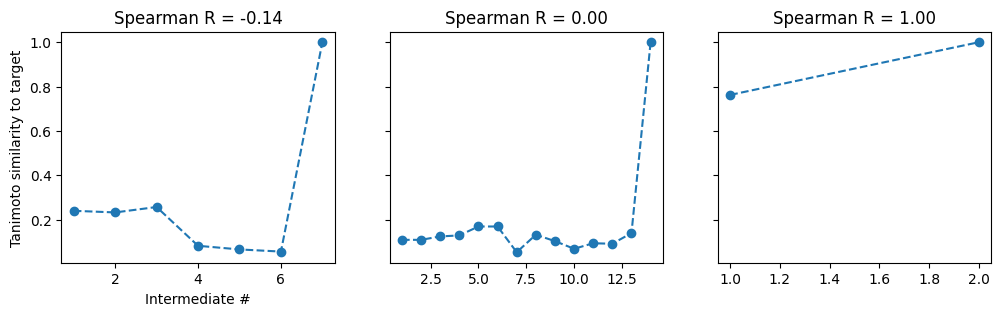

In [31]:
egs = [61, 601, 0]

fig, ax = plt.subplots(ncols=3, figsize=(12, 3), sharey=True)

def plot_eg(eg: int, ax, path_values: pd.DataFrame):
    trace = [float(elt) for elt in path_values.loc[eg, 'path_values'].split(',')]
    ax.set_title(f"Spearman R = {path_values.loc[eg, 'spearman_r']:.2f}")
    ax.plot(np.arange(1, len(trace) + 1), trace, linestyle='--', marker='o')

# plot_it = lambda i, st : ax[i].plot(np.arange(1, len(traces[i][st]) + 1), traces[i][st], linestyle='--', marker='o')

for i, eg in enumerate(egs):
    plot_eg(eg, ax[i], path_values)

ax[0].set_ylabel(f"Tanimoto similarity to target")
ax[0].set_xlabel("Intermediate #")
plt.show()

In [44]:
def show_path(pair, topk = 1):
    source, target = pair
    overall = ">>".join((G.nodes[source]['smiles'], G.nodes[target]['smiles']))
    print("Overall: ".upper(), f"{G.nodes[source]['names']} >> {G.nodes[target]['names']}")
    sr = path_values.loc[(path_values['starter_id'] == source) & (path_values['target_id'] == target), 'spearman_r'].values[0]
    print(f"Spearman: {sr:.2f}")
    display(SVG(draw_reaction(overall)))
    node_path, edge_path = G.shortest_path(source, target, rm_req_target=False)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

In [46]:
options = [(idx, path_values.loc[idx, ['starter_id', 'target_id']].to_list()) for idx in egs]
dd = widgets.Dropdown(options=options, value=options[0][1])

_ = interact(show_path, pair=dd)

interactive(children=(Dropdown(description='pair', options=((61, [0, 58]), (601, [0, 2385]), (0, [0, 1])), val…

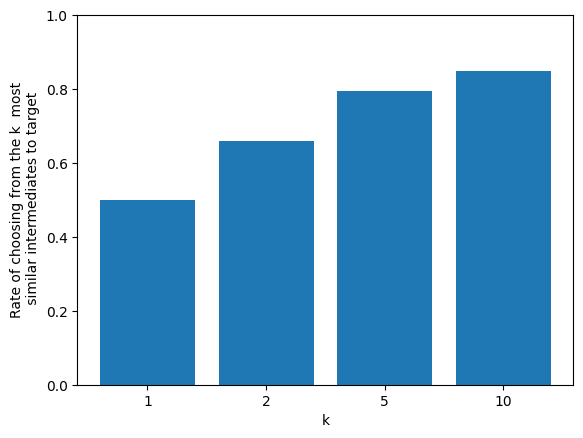

In [47]:
fig, ax = plt.subplots()
ax.bar([i for i in range(len(topks))], topks.values(), tick_label=topks.keys())
ax.set_ylim(0, 1)
ax.set_xlabel("k")
ax.set_ylabel("Rate of choosing from the k  most\n similar intermediates to target")
plt.show()


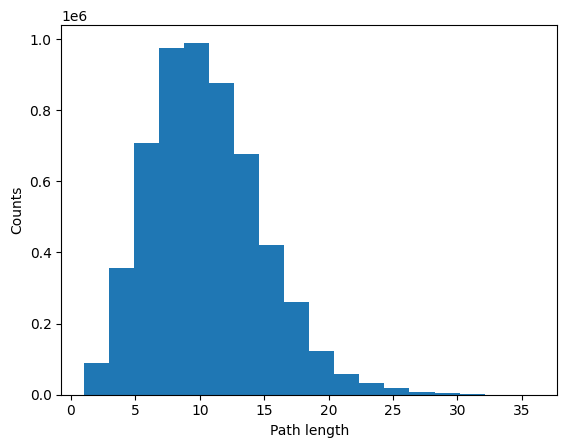

In [48]:
flat_lens = list(path_lens.values())
fig, ax = plt.subplots()
ax.hist(flat_lens, bins=18)
ax.set_ylabel("Counts")
ax.set_xlabel("Path length")
plt.show()

In [58]:
max(flat_lens)

48

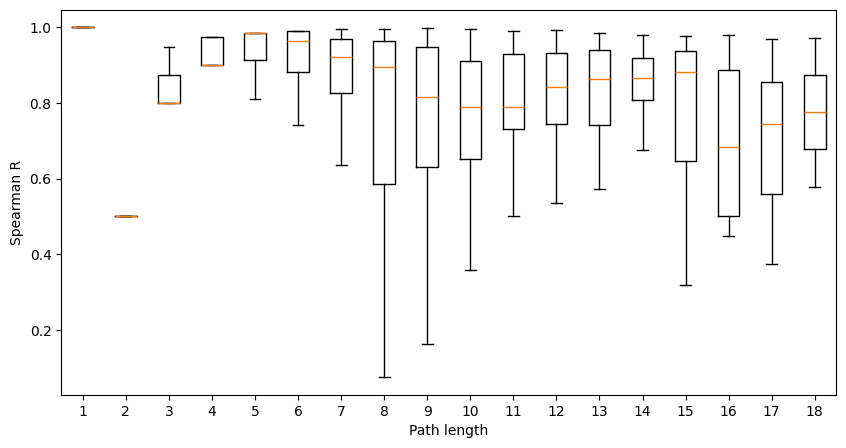

In [50]:
spearman_by_len = defaultdict(list)
for i in list(paths.keys())[::ds]:
    for j in paths[i]:
        plen = path_lens[(i, j)]
        r = path_values.loc[(path_values['starter_id'] == i) & (path_values['target_id'] == j), 'spearman_r'].values[0]
        spearman_by_len[plen].append(r)

x = sorted(spearman_by_len.keys())
stats = []
box_data = []
for elt in x:
    scatter = np.array(spearman_by_len[elt])
    stats.append((scatter.mean(), scatter.std()))
    box_data.append(scatter)


mu, sig = zip(*stats)

fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(box_data, positions=x, showfliers=False)
ax.set_ylabel("Spearman R")
ax.set_xlabel("Path length")
plt.show()


In [60]:
# # NOTE: this will have to change after change coreactant whitelist

# import krxns
# from collections import Counter
# from itertools import product
# def count_coreactant_debts(edge_path: list, coreactant_whitelist: dict):
#     paths = product(*edge_path) # Get all possible paths given multipath
#     for path in paths:
#         coreactant_counter = Counter()
#         for step in path:
#             for rct, stoich in step['requires'].items():
#                 if rct in coreactant_whitelist:
#                     coreactant_counter[rct] -= stoich
#                 else:
#                     print(f"{rct} found not in whitelist...")
#             for pdt, stoich in step['other_products'].items():
#                 if pdt in coreactant_whitelist:
#                     coreactant_counter[pdt] += stoich
                

#         # print(coreactant_counter)
#         # debts = {}
#         # counted_other = set()
#         # for smi in sorted(coreactant_counter.keys()):
#         #     if smi in counted_other:
#         #         continue
#         #     else:



# _, edge_path = G.shortest_path(0, 8735)
# count_coreactant_debts(edge_path, coreactant_whitelist)


